# Transformers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers , models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1)Veri Setini Yükleme

In [2]:
# En çok kullanılan 10000 kelimeyi kullan
max_feature = 10000
# Her yorumun max uzunluğu
max_len = 100

#IMDB
(x_train , y_train) , (x_test , y_test) = imdb.load_data(num_words = max_feature)

Yorumların uzunlukları max 100 olacak şekilde ayarlanacak  

In [3]:
x_train = pad_sequences(x_train , maxlen = max_len)
x_test = pad_sequences(x_test , maxlen = max_len)

IMDB kelime indekslerini al

In [4]:
word_index = imdb.get_word_index()

Kelimelerin dizinini geri döndürmek için ters çevirelim

In [5]:
reverse_word_index = { index + 3 : word for word , index in word_index.items() }
reverse_word_index[0] = "<POD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

### 2)Örnek Metinlerin Yazılması

In [6]:
# Her sayıyı kelimeye çevirme işlemi
def decode_review(encoded_review):
    return " ".join([reverse_word_index.get(i,"?") for i in encoded_review])

Rastgele 3 örnek yazdıralım

In [7]:
random_indicies = np.random.choice(len(x_train),size = 3 , replace = False)
for i in random_indicies:
    print(f"Yorum : {decode_review(x_train[i])}")
    print(f"Etiket : {y_train[i]}")
    print()

Yorum : main inspiration even his sexy girlfriend gets mad because now he does not pays the adequate attention to her br br well this is an indie movie with an edge but not for everyone it may seem boring or pretentious for some people but still i think it <UNK> a watch only because it offers something different than hollywood's typical standards br br to describe in a few words this is the typical christina <UNK> and john waters movie that's it br br oh and i almost forgot to mention that the full of grace lines are really annoying <UNK>
Etiket : 1

Yorum : how people get to this point a week after seeing this film i still think about it br br those of you who have not seen zero day please keep in mind the following the film is an independent with little to no budget and the film is shot on <UNK> the material in the film is disturbing this is not mainstream hollywood and there is no happy ending br br but if you can put all that aside zero day is a film that will stick with you and ju

### 3)Transformer Katmanı

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self , embed_size , heads , dropout_rate = 0.1):
        super(TransformerBlock , self).__init__()

        self.attention = layers.MultiHeadAttention(num_heads = heads , key_dim = embed_size)
        self.norm1 = layers.LayerNormalization(epsilon = 1e-6 )
        self.norm2 = layers.LayerNormalization(epsilon = 1e-6 )

        self.feed_forward = models.Sequential([
            layers.Dense(embed_size * 4 , activation = "relu"),
            layers.Dense(embed_size)
        ])

        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self,x,training =False):
        # Attention mekanizmasını uygulayalım
        attention = self.attention(x,x)
        x = self.norm1(x + self.dropout1(attention,training = training))
        feed_forward = self.feed_forward(x)
        return self.norm2(x + self.dropout2(feed_forward , training = training))

### 4)Transformer Modeli

In [9]:
class TransformerModel(models.Model):
    
    def __init__(self , num_layers , embed_size , heads , input_dim , output_dim , dorpout_rate = 0.1):
        super(TransformerModel,self).__init__()
        self.embedding = layers.Embedding(input_dim = input_dim , output_dim = embed_size )
        self.transformer_blocks = [TransformerBlock(embed_size, heads,dropout_rate) for _ in range(num_layers)]
        self.global_avg_pooling = layers.GlobalAveragePooling1D()
        self.dropout = layers.Dropout(dropout_rate)
        self.fc = layers.Dense(output_dim , activation = "sigmoid")

    def call(self, x, training =False):
        x = self.embedding(x)
        for transformer in self.transformer_blocks:
            x = transformer(x, training = training)
        x = self.global_avg_pooling(x)
        x = self.dropout(x, training = training)
        
        return self.fc(x) 

### 5)Model Eğitimi

In [10]:
# Hyperparametre Tanımı
# Kullanılacak Transformer katmanı
num_layers = 4
embed_size = 64 
# Multi-Head Sayısı
num_heads = 4
input_dim = max_feature
#İkili Sınıflandırma
output_dim = 1
dropout_rate = 0.1

# Modeli Oluştruma 
model = TransformerModel(num_layers , embed_size , num_heads , input_dim , output_dim , dropout_rate)

#Dummy veri ile derlenmesi sağlanır
dummy_input = tf.random.uniform((1, max_len), minval=0, maxval=max_feature, dtype=tf.int32)
model(dummy_input)

# Modeli bir giriş verisi ile çağırarak inşaa etme
# model.build(input_shape=(None,max_len,input_dim))

# Compile
model.compile(optimizer = "adam" , loss = "binary_crossentropy" , metrics = ["accuracy"])
model.summary()

Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 64)                │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ ?                           │          99,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ ?                           │          99,712 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │          99,712 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │          99,712 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,038,913 (3.96 MB)

 Trainable params: 1,038,913 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

Modelin Eğitimi

In [11]:
history = model.fit(x_train,y_train,epochs = 5 , batch_size = 256 , validation_data=(x_test,y_test))

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.6071 - loss: 0.6844 - val_accuracy: 0.8190 - val_loss: 0.4032
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8801 - loss: 0.2917 - val_accuracy: 0.8478 - val_loss: 0.3509
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9220 - loss: 0.2099 - val_accuracy: 0.8413 - val_loss: 0.3846
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9414 - loss: 0.1606 - val_accuracy: 0.8287 - val_loss: 0.4652
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9539 - loss: 0.1302 - val_accuracy: 0.8229 - val_loss: 0.4681


### 6)Modelin Test Edilmesi

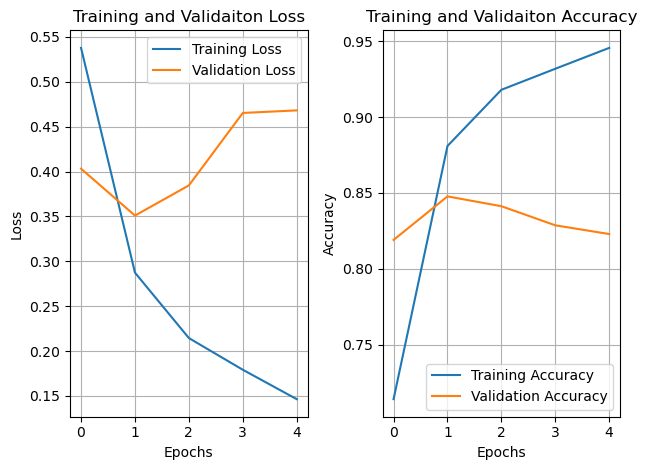

In [12]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Training and Validaiton Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Training and Validaiton Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()